# Transformer

## 1. 背景
Transformer 模型由 Vaswani 等人在 2017 年的论文《Attention is All You Need》中提出，旨在解决序列建模任务（如机器翻译）中的长距离依赖问题。与传统的 RNN 和 CNN 不同，Transformer 完全基于自注意力机制（Self-Attention），摒弃了递归和卷积结构，从而实现了更高的并行性和更好的长距离依赖捕捉能力。

## 2. 核心结构
Transformer 模型由编码器（Encoder）和解码器（Decoder）两部分组成，每部分由多个相同的层堆叠而成。

### 2.1 编码器（Encoder）
编码器由 $N$ 个相同的层组成，每层包含两个子层：
1. **多头自注意力机制（Multi-Head Self-Attention）**
2. **前馈神经网络（Feed-Forward Neural Network）**

每个子层后都接有残差连接（Residual Connection）和层归一化（Layer Normalization）。

### 2.2 解码器（Decoder）
解码器也由 $N$ 个相同的层组成，每层包含三个子层：
1. **掩码多头自注意力机制（Masked Multi-Head Self-Attention）**
2. **多头注意力机制（Multi-Head Attention）**
3. **前馈神经网络（Feed-Forward Neural Network）**

同样，每个子层后都有残差连接和层归一化。

## 3. 自注意力机制（Self-Attention）
自注意力机制是 Transformer 的核心。它通过计算序列中每个元素与其他元素的相关性，动态地分配注意力权重。

### 3.1 计算过程
1. **输入表示**：输入序列 $X = (x_1, x_2, \dots, x_n)$ 经过线性变换得到查询（Query）、键（Key）和值（Value）向量：
   $$
   Q = XW_Q, \quad K = XW_K, \quad V = XW_V
   $$
2. **注意力得分**：计算查询和键的点积，并除以 $\sqrt{d_k}$（$d_k$ 是键向量的维度）：
   $$
   \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
   $$
3. **多头注意力**：将上述过程重复 $h$ 次，得到 $h$ 个注意力头，然后将它们拼接并线性变换：
   $$
   \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h)W_O
   $$

## 4. 位置编码（Positional Encoding）
由于 Transformer 没有递归结构，无法直接捕捉序列的顺序信息。因此，引入了位置编码来为输入序列添加位置信息：
$$
PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d}}\right), \quad PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d}}\right)
$$
其中，$pos$ 是位置索引，$i$ 是维度索引。

## 5. 前馈神经网络（Feed-Forward Neural Network）
每个注意力子层后接一个前馈神经网络，通常由两个线性变换和一个激活函数组成：
$$
\text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2
$$

## 6. 训练与推理
- **训练**：使用交叉熵损失函数进行优化，通常采用 Adam 优化器。
- **推理**：解码器通过自回归方式生成输出序列，每一步生成一个 token。

## 7. 优点
1. **并行性**：Transformer 摒弃了递归结构，能够并行处理整个序列。
2. **长距离依赖**：自注意力机制能够直接捕捉序列中任意两个元素之间的关系。
3. **可扩展性**：通过堆叠更多的层和增加注意力头的数量，可以轻松扩展模型。

## 8. 应用
Transformer 模型在自然语言处理（NLP）领域取得了巨大成功，广泛应用于：
- 机器翻译
- 文本生成
- 文本分类
- 问答系统
- 语音识别

## 9. 总结
Transformer 模型通过自注意力机制和前馈神经网络的结合，实现了高效的序列建模。其并行性和长距离依赖捕捉能力使其在多个 NLP 任务中表现出色。尽管 Transformer 的计算复杂度较高，但其强大的性能和灵活性使其成为深度学习领域的重要里程碑。

# 实现

In [1]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

## 基于位置的前馈网络

In [2]:
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        """
        初始化函数
        :param ffn_num_input: 输入特征的维度
        :param ffn_num_hiddens: 隐藏层的维度
        :param ffn_num_outputs: 输出特征的维度
        :param kwargs: 其他传递给nn.Module的参数
        """
        super(PositionWiseFFN, self).__init__(**kwargs)
        # 第一个全连接层，将输入特征映射到隐藏层
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        # ReLU激活函数，引入非线性
        self.relu = nn.ReLU()
        # 第二个全连接层，将隐藏层的特征映射到输出层
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        """
        前向传播函数
        :param X: 输入张量，形状为(batch_size, seq_length, ffn_num_input)
        :return: 输出张量，形状为(batch_size, seq_length, ffn_num_outputs)
        """
        # 首先通过第一个全连接层，然后应用ReLU激活函数
        hidden = self.relu(self.dense1(X))
        # 再通过第二个全连接层得到最终输出
        output = self.dense2(hidden)
        return output

下面给出一个例子，示，改变张量的最里层维度的尺寸，会改变成基于位置的前馈网络的输出尺寸。因为用同一个多层感知机对所有位置上的输入进行变换，所以当所有这些位置的输入相同时，它们的输出也是相同的。

In [3]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[ 0.1128, -0.2276,  0.1759, -0.2494, -0.3903, -0.2489,  1.1889, -0.2425],
        [ 0.1128, -0.2276,  0.1759, -0.2494, -0.3903, -0.2489,  1.1889, -0.2425],
        [ 0.1128, -0.2276,  0.1759, -0.2494, -0.3903, -0.2489,  1.1889, -0.2425]],
       grad_fn=<SelectBackward0>)

## 残差连接和层规范化

以下代码对比不同维度的层规范化和批量规范化的效果。

In [4]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# 在训练模式下计算X的均值和方差
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


现在可以使用残差连接和层规范化来实现AddNorm类。暂退法也被作为正则化方法使用。

In [5]:
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        """
        初始化函数
        :param normalized_shape: 层归一化的归一化维度
        :param dropout: Dropout层的丢弃概率
        :param kwargs: 其他传递给nn.Module的参数
        """
        super(AddNorm, self).__init__(**kwargs)
        # 定义Dropout层，用于正则化
        self.dropout = nn.Dropout(dropout)
        # 定义层归一化层，对指定维度进行归一化
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        """
        前向传播函数
        :param X: 残差连接的输入张量
        :param Y: 残差连接的输出张量
        :return: 经过残差连接和层归一化后的张量
        """
        # 对Y应用Dropout操作
        Y_dropout = self.dropout(Y)
        # 残差连接：将Dropout后的Y与X相加
        residual = Y_dropout + X
        # 应用层归一化
        output = self.ln(residual)
        return output

残差连接要求两个输入的形状相同，以便加法操作后输出张量的形状相同。

## 编码器

有了组成Transformer编码器的基础组件，现在可以先实现编码器中的一个层。下面的EncoderBlock类包含两个子层：多头自注意力和基于位置的前馈网络，这两个子层都使用了残差连接和紧随的层规范化。

In [6]:
class EncoderBlock(nn.Module):
    """Transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        """
        初始化函数
        :param key_size: 键（Key）的维度
        :param query_size: 查询（Query）的维度
        :param value_size: 值（Value）的维度
        :param num_hiddens: 隐藏层的维度
        :param norm_shape: 层归一化的归一化维度
        :param ffn_num_input: 前馈网络的输入维度
        :param ffn_num_hiddens: 前馈网络的隐藏层维度
        :param num_heads: 多头注意力机制中的头数
        :param dropout: Dropout层的丢弃概率
        :param use_bias: 是否在多头注意力机制中使用偏置项
        :param kwargs: 其他传递给nn.Module的参数
        """
        super(EncoderBlock, self).__init__(**kwargs)
        # 多头自注意力机制
        self.attention = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        # 第一个残差连接和层归一化
        self.addnorm1 = AddNorm(norm_shape, dropout)
        # 前馈网络
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        # 第二个残差连接和层归一化
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        """
        前向传播函数
        :param X: 输入张量，形状为(batch_size, seq_length, num_hiddens)
        :param valid_lens: 有效长度，用于处理填充部分
        :return: 编码器块的输出
        """
        # 多头自注意力机制的输出
        attention_output = self.attention(X, X, X, valid_lens)
        # 第一个残差连接和层归一化
        Y = self.addnorm1(X, attention_output)
        # 前馈网络的输出
        ffn_output = self.ffn(Y)
        # 第二个残差连接和层归一化
        output = self.addnorm2(Y, ffn_output)
        return output

Transformer编码器中的任何层都不会改变其输入的形状

In [7]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

接下来实现的是编码器，在下面实现的Transformer编码器的代码中，堆叠了num_layers个EncoderBlock类的实例。由于这里使用的是值范围在−1和1之间的固定位置编码，因此通过学习得到的输入的嵌入表示的值需要先乘以嵌入维度的平方根进行重新缩放，然后再与位置编码相加。

In [8]:
class TransformerEncoder(d2l.Encoder):
    """Transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        # 词嵌入层，将词汇索引转换为词嵌入向量
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        # 位置编码器，为词嵌入向量添加位置信息
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        # 由多个编码器块组成的序列
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # 词嵌入并乘以嵌入维度的平方根进行缩放，然后添加位置编码
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        # 保存每个编码器块的注意力权重
        self.attention_weights = [None] * len(self.blks)
        # 逐层处理编码器块
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

下面我们指定了超参数来创建一个两层的Transformer编码器。Transformer编码器输出的形状是（批量大小，时间步数目，num_hiddens）。

In [9]:
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

## 解码器

Transformer解码器也是由多个相同的层组成。在DecoderBlock类中实现的每个层包含了三个子层：解码器自注意力、“编码器‐解码器”注意力和基于位置的前馈网络。这些子层也都被残差连接和紧随的层规范化围绕。

In [10]:
class DecoderBlock(nn.Module):
    """解码器中第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        # 第一个多头自注意力机制
        self.attention1 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        # 第一个残差连接和层归一化
        self.addnorm1 = AddNorm(norm_shape, dropout)
        # 第二个多头注意力机制（编码器-解码器注意力）
        self.attention2 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        # 第二个残差连接和层归一化
        self.addnorm2 = AddNorm(norm_shape, dropout)
        # 前馈网络
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        # 第三个残差连接和层归一化
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同一时间处理，
        # 因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元一个接着一个解码的，
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values

        if self.training:
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens的开头:(batch_size,num_steps),
            # 其中每一行是[1,2,...,num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # 自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # 编码器－解码器注意力。
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

为了便于在“编码器－解码器”注意力中进行缩放点积计算和残差连接中进行加法计算，编码器和解码器的特征维度都是num_hiddens。

In [11]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

现在将上述解码器块用到，组成的完整的Transformer解码器

In [12]:
class TransformerDecoder(d2l.AttentionDecoder):
    """Transformer解码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        # 词嵌入层
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        # 位置编码器
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        # 由多个解码器块组成的序列
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        # 线性层，用于生成最终的预测
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # 初始化解码器状态
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        # 词嵌入并乘以嵌入维度的平方根进行缩放，然后添加位置编码
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        # 保存每个解码器块的注意力权重
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        # 逐层处理解码器块
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 保存解码器自注意力权重
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # 保存编码器-解码器注意力权重
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        # 通过线性层生成最终的预测
        return self.dense(X), state

    @property
    def attention_weights(self):
        # 提供一个属性接口，用于获取解码器的注意力权重
        return self._attention_weights

## 训练

loss 0.032, 2298.3 tokens/sec on cuda:0


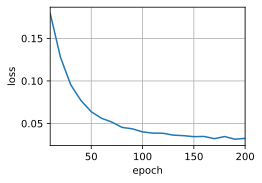

In [13]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

与之前类似，经过训练后现在进行训练结果的测试

In [14]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
        f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000


可见，效果是非常好的

当进行最后一个英语到法语的句子翻译工作时，让我们可视化Transformer的注意力权重。编码器自注意力权重的形状为（编码器层数，注意力头数，num_steps或查询的数目，num_steps或“键－值”对的数目）。

In [15]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
-1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

在编码器的自注意力中，查询和键都来自相同的输入序列。因为填充词元是不携带信息的，因此通过指定输入序列的有效长度可以避免查询与使用填充词元的位置计算注意力。接下来，将逐行呈现两层多头注意力的权重。每个注意力头都根据查询、键和值的不同的表示子空间来表示不同的注意力。

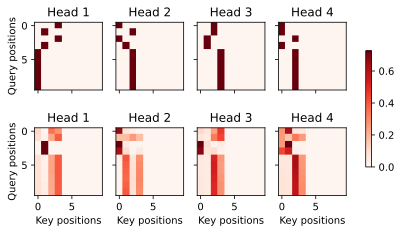

In [16]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

为了可视化解码器的自注意力权重和“编码器－解码器”的注意力权重，我们需要完成更多的数据操作工作。例如用零填充被掩蔽住的注意力权重。值得注意的是，解码器的自注意力权重和“编码器－解码器”的注意力权重都有相同的查询：即以序列开始词元（beginning‐of‐sequence,BOS）打头，再与后续输出的词元共同组成序列。

In [22]:
# 将解码器的注意力权重序列转换为二维列表
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step 
                            for blk in attn 
                            for head in blk]

# 将二维列表转换为Pandas DataFrame，填充缺失值为0.0，并转换为PyTorch张量
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)

# 将填充后的张量重新调整为5维张量，形状为 (batch_size, 2, num_layers, num_heads, num_steps)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))

# 通过permute函数重新排列维度，并解包为自注意力权重和交叉注意力权重
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)

# 输出自注意力权重和交叉注意力权重的形状
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

由于解码器自注意力的自回归属性，查询不会对当前位置之后的“键－值”对进行注意力计算。

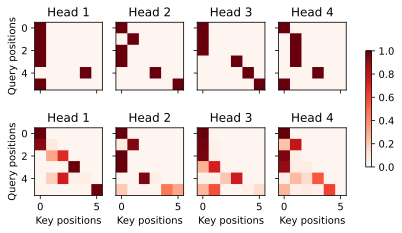

In [20]:
# Plusonetoincludethebeginning-of-sequencetoken
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

与编码器的自注意力的情况类似，通过指定输入序列的有效长度，输出序列的查询不会与输入序列中填充位置的词元进行注意力计算

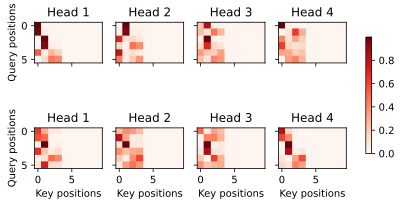

In [21]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))